<a href="https://colab.research.google.com/github/yuvalira/Monet_style_transfer/blob/main/models/Monet_CycleGAN_ImprovedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Improved Model

This notebook extends the **vanilla CycleGAN baseline** with meaningful improvements:  
- **Self-Attention blocks** to capture long-range dependencies.  
- **Perceptual loss (VGG-based)** to preserve higher-level structure.  
- **Additional LSGAN losses** to stabilize training.  
- **Deeper generator and discriminator** with more filters.  

We compare this model to the baseline using the official **MiFID** metric and side-by-side qualitative results.


## Setup & Imports

In [ ]:
# ===== Standard Library =====
import os
import random
import csv
from pathlib import Path

# ===== Math & Data =====
import numpy as np

# ===== Visualization =====
import matplotlib.pyplot as plt
from PIL import Image

# ===== TensorFlow & Addons =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# ===== Custom Modules =====
import MiFID as mf

# ===== TPU / Strategy Setup =====
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

# ===== Autotune & Version Info =====
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.6.2


/home/shaharai/.conda/envs/Cygan/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/shaharai/.conda/envs/Cygan/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an

## Load and Preprocess Dataset


In [ ]:
GCS_PATH = '/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/gan-getting-started/'

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord_with_name(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    ex = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_image(ex["image"])
    return img, ex["image_name"]


def read_tfrecord(example):
    img, _ = read_tfrecord_with_name(example)
    return img

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False, with_name=False):
    ds = tf.data.TFRecordDataset(filenames)
    if with_name:
        ds = ds.map(read_tfrecord_with_name, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(read_tfrecord,            num_parallel_calls=AUTOTUNE)
    return ds

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2025-08-18 16:40:54.697031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-18 16:40:54.854601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46566 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:21:00.0, compute capability: 8.9


**Color Distribution Matching - Data Preprocessing**

In [ ]:
def compute_channel_stats(ds, take=None):
    total = 0
    s  = np.zeros(3, dtype=np.float64)
    s2 = np.zeros(3, dtype=np.float64)
    it = ds if take is None else ds.take(take)
    for img in it:
        if isinstance(img, (tuple, list)):
            img = img[0]
        x = img.numpy().reshape(-1, 3).astype(np.float64)  # [-1,1]
        s  += x.sum(axis=0)
        s2 += np.square(x).sum(axis=0)
        total += x.shape[0]
    mean = s / total
    var  = s2 / total - np.square(mean)
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

def build_channel_matcher(src_mean, src_std, tgt_mean, tgt_std):
    scale = (tgt_std / np.maximum(src_std, 1e-8)).astype(np.float32)
    shift = (tgt_mean - src_mean * scale).astype(np.float32)
    scale_tf = tf.constant(scale, dtype=tf.float32)
    shift_tf = tf.constant(shift, dtype=tf.float32)
    def preprocess(img):
        y = img * scale_tf + shift_tf
        return tf.clip_by_value(y, -1.0, 1.0)
    return preprocess, scale, shift

# compute stats on datasets
photo_mean, photo_std = compute_channel_stats(photo_ds)
monet_mean, monet_std = compute_channel_stats(monet_ds)

# build the preprocessing fn and apply it to the photo stream
preprocess_photo_to_monet, scale_vec, shift_vec = build_channel_matcher(
    photo_mean, photo_std, monet_mean, monet_std
)
photo_ds = photo_ds.map(preprocess_photo_to_monet, num_parallel_calls=tf.data.AUTOTUNE)


2025-08-18 16:40:55.200151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Generator



In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

**Improvement 1: Self-Attention Blocks**

We added **self-attention** layers at several resolutions in the generator (and one in the discriminator). These layers let each spatial location attend to others, not just its local neighborhood.

The idea: Monet’s style involves **global color layouts** and long brush patterns. Self-attention captures **long-range dependencies**, improving global coherence (e.g., sky-water harmony) while preserving important objects.


In [ ]:
class SelfAttention(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels

        # Give unique names to internal layers using self.name
        self.query_conv = layers.Conv2D(
            channels // 4, 1,
            name=f'{self.name}_query_conv'
        )
        self.key_conv = layers.Conv2D(
            channels // 4, 1,
            name=f'{self.name}_key_conv'
        )
        self.value_conv = layers.Conv2D(
            channels, 1,
            name=f'{self.name}_value_conv'
        )
        self.gamma = self.add_weight(
            name=f'{self.name}_gamma',  # Also make gamma name unique
            shape=(),
            initializer='zeros',
            trainable=True
        )

    def call(self, x):
        batch_size, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]

        # Generate query, key, value with wider channels
        query = self.query_conv(x)  # [batch_size, height, width, channels//4]
        key = self.key_conv(x)      # [batch_size, height, width, channels//4]
        value = self.value_conv(x)  # [batch_size, height, width, channels]

        # Reshape for matrix multiplication
        query = tf.reshape(query, [batch_size, height * width, channels // 4])
        key = tf.reshape(key, [batch_size, height * width, channels // 4])
        value = tf.reshape(value, [batch_size, height * width, channels])

        # Compute attention weights
        attention = tf.nn.softmax(tf.matmul(query, key, transpose_b=True), axis=-1)

        # Apply attention to values
        out = tf.matmul(attention, value)
        out = tf.reshape(out, [batch_size, height, width, channels])

        # Apply learnable parameter gamma and residual connection
        out = self.gamma * out + x

        return out

    def get_config(self):
        config = super().get_config()
        config.update({'channels': self.channels})
        return config

**Improvement 2: Deeper, Wider Generator (with Attention)**

We increased filters and depth in the U-Net and insert attention at key scales (e.g., 64×64, 32×32, 8×8). Keep skip connections and `tanh` output in [-1, 1].

The idea: More capacity = better ability to model **rich textures** and color transitions typical of Monet. Attention acts as a **capacity moderator**, helping the larger network use its parameters on globally consistent style rather than overfitting to local noise.


In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # Larger down_stack with more filters
    down_stack = [
        downsample(96, 4, apply_instancenorm=False), # (bs, 128, 128, 96) - increased from 64
        downsample(192, 4), # (bs, 64, 64, 192) - increased from 128
        downsample(384, 4), # (bs, 32, 32, 384) - increased from 256
        downsample(768, 4), # (bs, 16, 16, 768) - increased from 512
        downsample(768, 4), # (bs, 8, 8, 768)
        downsample(768, 4), # (bs, 4, 4, 768)
        downsample(768, 4), # (bs, 2, 2, 768)
        downsample(768, 4), # (bs, 1, 1, 768)
    ]

    # Larger up_stack with corresponding filter increases
    up_stack = [
        upsample(768, 4, apply_dropout=True), # (bs, 2, 2, 1536)
        upsample(768, 4, apply_dropout=True), # (bs, 4, 4, 1536)
        upsample(768, 4, apply_dropout=True), # (bs, 8, 8, 1536)
        upsample(768, 4), # (bs, 16, 16, 1536)
        upsample(384, 4), # (bs, 32, 32, 768) - increased from 256
        upsample(192, 4), # (bs, 64, 64, 384) - increased from 128
        upsample(96, 4), # (bs, 128, 128, 192) - increased from 64
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model with more self-attention
    skips = []
    for i, down in enumerate(down_stack):
        x = down(x)
        # Add self-attention at more layers for larger model
        if i == 1:  # After 192 filters layer (64x64 resolution)
            x = SelfAttention(192)(x)
        elif i == 2:  # After 384 filters layer (32x32 resolution)
            x = SelfAttention(384)(x)
        elif i == 4:  # After 768 filters layer (8x8 resolution)
            x = SelfAttention(768)(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections with more self-attention
    for i, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        # Add self-attention at more upsampling layers
        if i == 1:  # After concatenation
            x = SelfAttention(1536)(x)
        elif i == 3:  # After concatenation
            x = SelfAttention(1536)(x)
        elif i == 5:  # After concatenation
            x = SelfAttention(384)(x)

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Discriminator



**Improvement 3: Stronger PatchGAN Discriminator + Attention**

We added an extra downsampling stage and more filters; insert a self-attention layer around the 32×32 feature scale.

The idea: a stronger discriminator better detects subtle artifacts in generated textures. Attention in D sharpens its ability to judge **contextual realism** (not just pixel-wise edges), pushing the generator toward more convincing Monet-like strokes.


In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # Larger discriminator with more layers and filters
    down1 = downsample(96, 4, False)(x) # (bs, 128, 128, 96) - increased from 64
    down2 = downsample(192, 4)(down1) # (bs, 64, 64, 192) - increased from 128
    down3 = downsample(384, 4)(down2) # (bs, 32, 32, 384) - increased from 256

    # Add self-attention to discriminator
    down3_att = SelfAttention(384)(down3)

    # Additional layer for larger discriminator
    down4 = downsample(768, 4)(down3_att) # (bs, 16, 16, 768) - new layer

    zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 18, 18, 768)
    conv = layers.Conv2D(768, 4, strides=1,  # increased from 512
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 15, 15, 768)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 768)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

**Improvement 4: Perceptual Loss (VGG19 Features)**

We used a pretrained **VGG19** to extract multi-layer feature maps from real vs. generated images and minimize their **feature-space distance** (L1).

The idea: perceptual loss preserves **content structure** (shapes, composition) beyond raw pixels, guiding the generator to keep scene layout while applying Monet’s style. This reduces distortions that can slip past pixel losses.


In [ ]:
# VGG Feature Extractor for Perceptual Loss
def create_vgg_feature_extractor():
    vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

    # Make all layer names unique by adding prefix
    for layer in vgg.layers:
        layer._name = f"vgg_perceptual_{layer.name}"

    # Extract features from multiple layers
    layer_names = ['vgg_perceptual_block1_conv1', 'vgg_perceptual_block2_conv1',
                   'vgg_perceptual_block3_conv1', 'vgg_perceptual_block4_conv1',
                   'vgg_perceptual_block5_conv1']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    model.trainable = False

    # Also rename the final model
    model._name = "vgg_perceptual_feature_extractor"

    return model

# Initialize VGG feature extractor
with strategy.scope():
    vgg_feature_extractor = create_vgg_feature_extractor()

## Build the CycleGAN model


In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        vgg_feature_extractor=None,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.vgg_feature_extractor = vgg_feature_extractor
        self.lambda_lsgan = 0.5

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        perceptual_loss_fn,
        lsgan_gen_loss_fn,
        lsgan_disc_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.perceptual_loss_fn = perceptual_loss_fn
        self.lsgan_gen_loss_fn = lsgan_gen_loss_fn
        self.lsgan_disc_loss_fn = lsgan_disc_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            monet_lsgan_gen_loss = self.lsgan_gen_loss_fn(disc_fake_monet)
            photo_lsgan_gen_loss = self.lsgan_gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates perceptual loss
            monet_perceptual_loss = self.perceptual_loss_fn(real_photo, fake_monet, self.vgg_feature_extractor)
            photo_perceptual_loss = self.perceptual_loss_fn(real_monet, fake_photo, self.vgg_feature_extractor)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle) + monet_perceptual_loss + self.lambda_lsgan * monet_lsgan_gen_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle) + photo_perceptual_loss + self.lambda_lsgan * photo_lsgan_gen_loss

            # evaluates discriminator loss
            monet_lsgan_disc_loss = self.lsgan_disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_lsgan_disc_loss = self.lsgan_disc_loss_fn(disc_real_photo, disc_fake_photo)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet) + self.lambda_lsgan * monet_lsgan_disc_loss
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo) + self.lambda_lsgan * photo_lsgan_disc_loss

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Define loss functions


In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

**Improvement 5: Auxiliary LSGAN Losses**

We Added **Least-Squares GAN** terms alongside the standard BCE adversarial losses for both G and D.

The idea: LSGAN penalizes predictions proportionally to their distance from the target labels (0/1), which often **stabilizes** updates and reduces gradient saturation. In practice, it smooths training and can yield **cleaner textures**.


In [ ]:
with strategy.scope():
    def lsgan_discriminator_loss(real, generated):
        # LSGAN discriminator loss: ½E[(D(x) - 1)²] + ½E[(D(G(z)))²]
        real_loss = tf.reduce_mean(tf.square(real - 1.0))
        generated_loss = tf.reduce_mean(tf.square(generated - 0.0))
        total_lsgan_disc_loss = real_loss + generated_loss
        return total_lsgan_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def lsgan_generator_loss(generated):
        # LSGAN generator loss: ½E[(D(G(z)) - 1)²]
        return tf.reduce_mean(tf.square(generated - 1.0))

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def perceptual_loss(real_image, generated_image, vgg_model, lambda_perceptual=0.002):
        # Preprocess images for VGG (convert from [-1,1] to [0,255] and then normalize)
        real_processed = tf.keras.applications.vgg19.preprocess_input((real_image + 1) * 127.5)
        generated_processed = tf.keras.applications.vgg19.preprocess_input((generated_image + 1) * 127.5)

        # Extract features
        real_features = vgg_model(real_processed)
        generated_features = vgg_model(generated_processed)

        # Compute loss at each layer
        perceptual_loss_value = 0
        for real_feat, gen_feat in zip(real_features, generated_features):
            perceptual_loss_value += tf.reduce_mean(tf.abs(real_feat - gen_feat))

        return lambda_perceptual * perceptual_loss_value

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train Model

In [ ]:
class EpochAverageLogs(tf.keras.callbacks.Callback):
    """
    Averages selected log keys over training batches so CSVLogger records clean scalars.
    """
    def __init__(self, keys):
        super().__init__()
        self.keys = tuple(keys)
        self._reset()

    def _reset(self):
        self.sums = {k: 0.0 for k in self.keys}
        self.count = 0

    def _to_float(self, v):
        if isinstance(v, (list, tuple)):
            return float(np.mean([self._to_float(x) for x in v]))
        if tf.is_tensor(v):
            v = v.numpy()
        if isinstance(v, np.ndarray):
            return float(np.mean(v))
        return float(v)

    def on_train_batch_end(self, batch, logs=None):
        if not logs:
            return
        self.count += 1
        for k in self.keys:
            if k in logs:
                try:
                    self.sums[k] += self._to_float(logs[k])
                except Exception:
                    pass  # ignore weird/unexpected types

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.count > 0:
            for k in self.keys:
                logs[k] = self.sums[k] / self.count
        self._reset()


In [ ]:
def run_training_once(seed: int,
                      out_root: str,
                      epochs: int = 25,
                      monet_files=MONET_FILENAMES,
                      photo_files=PHOTO_FILENAMES):


    # --------------------- Helpers ---------------------
    def set_global_seed(seed_val):
        os.environ["PYTHONHASHSEED"] = str(seed_val)
        random.seed(seed_val)
        np.random.seed(seed_val)
        tf.random.set_seed(seed_val)

    def make_outdir(root, seed_val):
        out = Path(root) / f"seed_{seed_val:04d}"
        (out / "images").mkdir(parents=True, exist_ok=True)
        (out / "ckpts").mkdir(parents=True, exist_ok=True)
        return out

    VALID_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

    def sanitize_fname(raw_name: str, default_ext: str) -> str:
        """Ensure basename only, valid extension, and trimmed/cleaned name."""
        p = Path(raw_name)
        base = p.name  # drop directories if any
        ext = Path(base).suffix.lower()
        if ext not in VALID_EXTS:
            base = Path(base).stem + default_ext
        # light cleanup
        base = base.replace("\n", "_").replace("\r", "_").strip()
        # avoid accidental empties
        if base == "" or base in {".", ".."}:
            base = f"img_{seed}_{np.random.randint(1e9)}{default_ext}"
        return base

    # If you sometimes output grayscale, prefer PNG by default for those cases
    def pick_default_ext(array_like) -> str:
        try:
            if array_like.ndim == 2:
                return ".png"
            if array_like.ndim == 3 and array_like.shape[-1] in (1,):
                return ".png"
            return ".jpg"
        except Exception:
            return ".jpg"

    # ---------------------- Build data ----------------------
    def build_datasets(monet_files, photo_files, batch_size=1, seed_val=0):
        # Monet: as-is (NO preprocessing)
        monet = load_dataset(monet_files)

        # Photo: apply channel-matching preprocessing ONLY to photos
        photo = load_dataset(photo_files)
        photo = photo.map(preprocess_photo_to_monet,
                          num_parallel_calls=tf.data.AUTOTUNE)

        monet = monet.shuffle(2048, seed=seed_val, reshuffle_each_iteration=True).batch(batch_size)
        photo = photo.shuffle(2048, seed=seed_val, reshuffle_each_iteration=True).batch(batch_size)
        return monet, photo

    # ---------------------- Setup ----------------------
    tf.keras.backend.clear_session()
    set_global_seed(seed)
    outdir = make_outdir(out_root, seed)
    print(f"\n=== Training seed {seed} ===\nOutputs -> {outdir}")

    monet_ds, photo_ds = build_datasets(monet_files, photo_files, batch_size=1, seed_val=seed)

    with strategy.scope():
        m_gen = Generator()
        p_gen = Generator()
        m_disc = Discriminator()
        p_disc = Discriminator()

        m_gen_opt  = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        p_gen_opt  = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        m_disc_opt = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        p_disc_opt = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)

        cyclegan = CycleGan(m_gen, p_gen, m_disc, p_disc, vgg_feature_extractor=vgg_feature_extractor)
        cyclegan.compile(
            m_gen_optimizer=m_gen_opt, p_gen_optimizer=p_gen_opt,
            m_disc_optimizer=m_disc_opt, p_disc_optimizer=p_disc_opt,
            gen_loss_fn=generator_loss, disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss, identity_loss_fn=identity_loss,
            perceptual_loss_fn = perceptual_loss,
            lsgan_gen_loss_fn = lsgan_generator_loss,
            lsgan_disc_loss_fn = lsgan_discriminator_loss
        )

    # ---------------------- Train ----------------------
    avg_cb = EpochAverageLogs(keys=[
        "monet_gen_loss", "photo_gen_loss",
        "monet_disc_loss", "photo_disc_loss"
    ])

    csv_logger = tf.keras.callbacks.CSVLogger(str(outdir / "training_log.csv"))
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=str(outdir / "ckpts" / "weights_epoch{epoch:03d}.weights.h5"),
        save_weights_only=True,
        save_best_only=False
    )

    cyclegan.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=epochs,
        callbacks=[avg_cb, csv_logger, ckpt_cb]
    )

    # ---------------- Save sub-model weights ----------------
    dummy = tf.zeros((1, 256, 256, 3))
    _ = m_gen(dummy); _ = p_gen(dummy); _ = m_disc(dummy); _ = p_disc(dummy)

    m_gen.save_weights(str(outdir / "m_gen_weights.weights.h5"))
    p_gen.save_weights(str(outdir / "p_gen_weights.weights.h5"))
    m_disc.save_weights(str(outdir / "m_disc_weights.weights.h5"))
    p_disc.save_weights(str(outdir / "p_disc_weights.weights.h5"))

    ckpt = tf.train.Checkpoint(
        m_gen=m_gen, p_gen=p_gen, m_disc=m_disc, p_disc=p_disc,
        m_gen_opt=m_gen_opt, p_gen_opt=p_gen_opt,
        m_disc_opt=m_disc_opt, p_disc_opt=p_disc_opt
    )
    ckpt_path = ckpt.save(str(outdir / "ckpts" / "ckpt"))
    print("Saved checkpoint:", ckpt_path)

    # ------------------ Export predictions ------------------
    # Unshuffled stream that yields (image, image_name)
    export_ds = load_dataset(photo_files, with_name=True)
    export_ds = export_ds.map(
        lambda img, name: (preprocess_photo_to_monet(img), name),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(1).prefetch(tf.data.AUTOTUNE)

    gen_dir = outdir / "generated_full"
    gen_dir.mkdir(exist_ok=True)

    for img, name in export_ds:
        # Predict in [-1, 1]
        pred = m_gen(img, training=False)[0].numpy()
        # Convert to uint8 [0, 255]
        pred_u8 = ((pred * 127.5) + 127.5).clip(0, 255).astype(np.uint8)

        # Get original filename and make it safe + with extension
        raw_name = name.numpy()[0].decode("utf-8")
        default_ext = pick_default_ext(pred_u8)
        safe_name = sanitize_fname(raw_name, default_ext)
        save_path = gen_dir / safe_name

        # Build PIL image and ensure mode is valid for the chosen format
        img_pil = Image.fromarray(pred_u8 if pred_u8.ndim == 2 or pred_u8.shape[-1] != 1
                                  else pred_u8.squeeze(-1))

        ext = save_path.suffix.lower()
        if ext in {".jpg", ".jpeg"} and img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        fmt = "JPEG" if ext in {".jpg", ".jpeg"} else "PNG" if ext == ".png" else None
        img_pil.save(save_path, format=fmt)

    return outdir

In [ ]:
OUTPUT_ROOT = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments"
SEEDS = [42, 17, 29]
EPOCHS = 50

run_dirs = []
for s in SEEDS:
    run_dirs.append(run_training_once(seed=s, out_root=OUTPUT_ROOT, epochs=EPOCHS))



=== Training seed 42 ===
Outputs -> /sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments/seed_0042
Epoch 1/50


2025-08-18 16:41:48.637137: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8907
2025-08-18 16:41:49.530284: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-18 16:41:49.530364: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


300/300 [==============================] - 84s 159ms/step - monet_gen_loss: 5.6409 - photo_gen_loss: 5.6916 - monet_disc_loss: 0.7886 - photo_disc_loss: 0.8124
Epoch 2/50
300/300 [==============================] - 49s 161ms/step - monet_gen_loss: 3.8429 - photo_gen_loss: 3.8895 - monet_disc_loss: 0.8272 - photo_disc_loss: 0.8147
Epoch 3/50
300/300 [==============================] - 48s 161ms/step - monet_gen_loss: 3.6133 - photo_gen_loss: 3.5027 - monet_disc_loss: 0.7749 - photo_disc_loss: 0.8105
Epoch 4/50
300/300 [==============================] - 48s 161ms/step - monet_gen_loss: 3.4507 - photo_gen_loss: 3.2883 - monet_disc_loss: 0.7764 - photo_disc_loss: 0.7892
Epoch 5/50
300/300 [==============================] - 49s 163ms/step - monet_gen_loss: 3.1421 - photo_gen_loss: 2.9973 - monet_disc_loss: 0.7789 - photo_disc_loss: 0.8100
Epoch 6/50
300/300 [==============================] - 49s 162ms/step - monet_gen_loss: 2.9014 - photo_gen_loss: 2.8168 - monet_disc_loss: 0.7715 - photo_dis

## Test

In [ ]:
OUTPUT_ROOT = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments"

# Collect all seed_xxxx folders inside OUTPUT_ROOT
run_dirs = sorted(Path(OUTPUT_ROOT).glob("seed_*"))
print(run_dirs)  # confirm we got them

[PosixPath('/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments/seed_0017'), PosixPath('/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments/seed_0029'), PosixPath('/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments/seed_0042')]


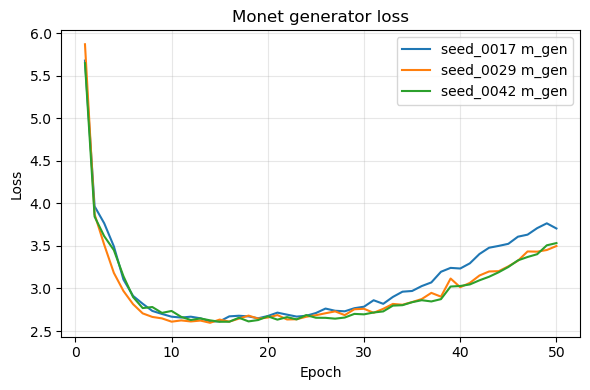

In [ ]:
plt.figure(figsize=(6, 4))

for rd in run_dirs:
    csv_path = Path(rd) / "training_log.csv"
    epochs, losses = [], []

    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            epochs.append(int(row["epoch"]) + 1)
            losses.append(float(row["monet_gen_loss"]))

    plt.plot(epochs, losses, label=f"{Path(rd).name} m_gen")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Monet generator loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:
# Paths
OUTPUT_ROOT = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/experiments"
DATA_ROOT   = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/gan-getting-started"
REAL_MONET_DIR = "/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/monet_jpgs_for_eval"

# Export Monet JPGs from TFRecords if needed
MONET_FILENAMES = tf.io.gfile.glob(str(Path(DATA_ROOT) / "monet_tfrec" / "*.tfrec"))
mf.ensure_monet_jpgs_from_tfrec(MONET_FILENAMES, REAL_MONET_DIR)

# Evaluate MiFID per run
run_dirs = sorted(p for p in Path(OUTPUT_ROOT).glob("seed_*") if p.is_dir())
rows = []
for rd in run_dirs:
    gen_dir = rd / "generated_full"
    res = mf.compute_mifid(REAL_MONET_DIR, gen_dir, epsilon=0.10, batch=64)
    rows.append({"run": rd.name, **res})

# Sort by MiFID
rows.sort(key=lambda r: r["MiFID"])

# Per-run table
print("\nMiFID results (sorted by MiFID):")
print(f"{'run':<12} {'FID':>10} {'d':>10} {'d_thr':>10} {'MiFID':>12}")
for r in rows:
    print(f"{r['run']:<12} {r['FID']:>10.4f} {r['d']:>10.4f} {r['d_thr']:>10.4f} {r['MiFID']:>12.4f}")

# Summary across runs (mean & std)
def mean_std(vals):
    arr = np.asarray(vals, dtype=float)
    n = arr.size
    mean = float(arr.mean()) if n else float("nan")
    std  = float(arr.std(ddof=1)) if n > 1 else 0.0
    return mean, std

metrics = ["FID", "MiFID"]
print("\nSummary across runs:")
print(f"{'metric':<8} {'mean':>12} {'std':>12}")
for m in metrics:
    mean, std = mean_std([r[m] for r in rows])
    print(f"{m:<8} {mean:>12.4f} {std:>12.4f}")

[mifid] Exported 300 Monet images to /sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/monet_jpgs_for_eval

MiFID results (sorted by MiFID):
run                 FID          d      d_thr        MiFID
seed_0042       85.6079     0.2458     1.0000      85.6079
seed_0017       87.5524     0.2477     1.0000      87.5524
seed_0029       88.2828     0.2487     1.0000      88.2828

Summary across runs:
metric           mean          std
FID           87.1477       1.3826
MiFID         87.1477       1.3826


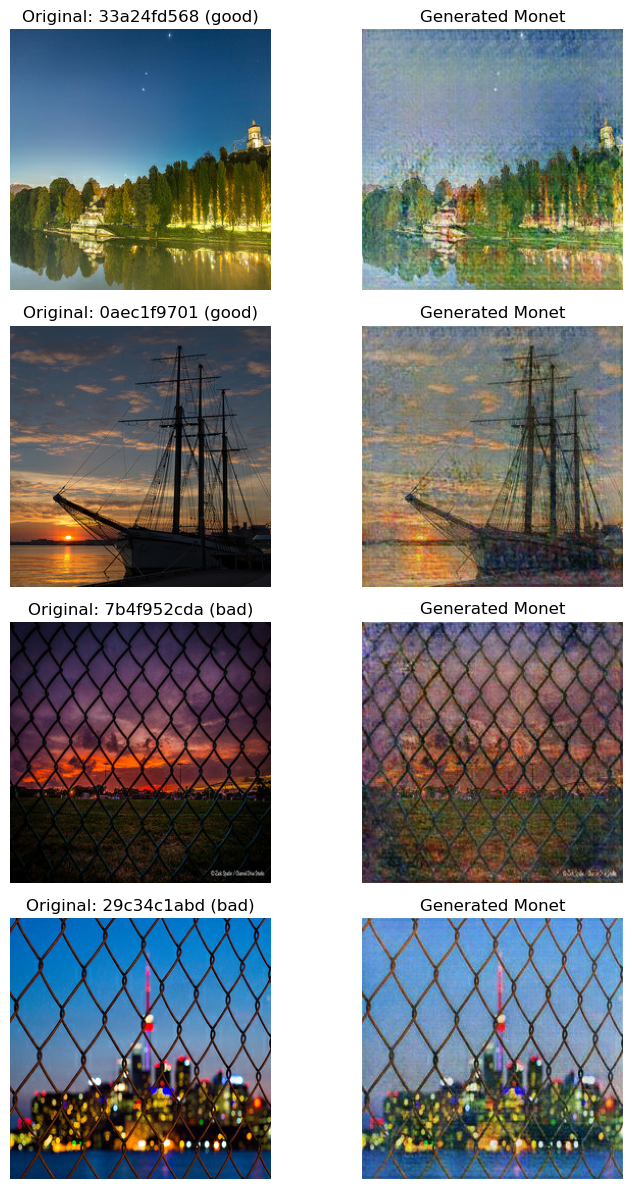

In [ ]:
# ---- paths ----
RUN_DIR = Path(OUTPUT_ROOT) / "seed_0042"
GEN_DIR = RUN_DIR / "generated_full"
REAL_MONET_DIR = Path("/sise/eliyanac-group/shaharai/IPFP/0818multipule_runs/ours_preproccess_data_50epochs/monet_jpgs_for_eval")

# ---- compute Inception features using MiFID helpers ---
real_paths = mf._list_images(REAL_MONET_DIR)
gen_paths  = mf._list_images(GEN_DIR)
assert len(real_paths) > 0 and len(gen_paths) > 0, "Empty real/gen image folders."

inc = mf.InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))
f_real = mf._get_inception_features(real_paths, inc, batch=64)
f_gen  = mf._get_inception_features(gen_paths,  inc, batch=64)

# distance per generated
D = mf._cosine_distance_matrix(f_gen, f_real)   # [Ngen, Nreal]
d_per_gen = D.min(axis=1)

# ---- pick 2 best (smallest d) and 2 worst (largest d) ----
idx_sorted = np.argsort(d_per_gen)
good_idx = idx_sorted[:2]
bad_idx  = idx_sorted[-2:]
sel_idx = list(good_idx) + list(bad_idx)

sel_gen_paths = [gen_paths[i] for i in sel_idx]
sel_names = [Path(p).name for p in sel_gen_paths]
labels = ["good", "good", "bad", "bad"]

# ---- fetch matching ORIGINAL photos ----
def norm_all_keys(name_str: str):
    bname = Path(name_str).name
    stem = Path(bname).stem
    return {bname.casefold(), stem.casefold()}

orig_map = {}
name_index = {}

photo_named_ds = load_dataset(PHOTO_FILENAMES, with_name=True).batch(1)
for img, name in photo_named_ds:
    nm = name.numpy()[0].decode("utf-8", errors="ignore")
    arr = img.numpy()[0]                                   # [-1,1]
    arr_u8 = ((arr * 127.5) + 127.5).clip(0, 255).astype(np.uint8)

    for k in norm_all_keys(nm):
        if k not in orig_map:
            orig_map[k] = arr_u8
    name_index[Path(nm).stem.casefold()] = Path(nm).name

resolved_pairs = []
missing = []

for gen_p in sel_gen_paths:
    gen_name = Path(gen_p).name
    found = None
    for k in norm_all_keys(gen_name):
        if k in orig_map:
            found = k
            break
    if found is None:
        missing.append(gen_name)
    else:
        orig_img = orig_map[found]
        gen_img = np.array(Image.open(gen_p))
        pretty = name_index.get(Path(gen_name).stem.casefold(), gen_name)
        resolved_pairs.append((pretty, orig_img, gen_img))

assert not missing, f"Could not find originals for: {missing}"

# ---- show side-by-side ----
fig, axes = plt.subplots(len(resolved_pairs), 2, figsize=(8, 3*len(resolved_pairs)))
if len(resolved_pairs) == 1:
    axes = np.array([axes])

for row, (disp_name, orig_img, gen_img) in enumerate(resolved_pairs):
    tag = labels[row]

    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"Original: {disp_name} ({tag})")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(gen_img)
    axes[row, 1].set_title("Generated Monet")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()